In [1]:
import sys
# append the path of the parent directory
sys.path.append("..")

In [268]:
import math
import os
import time


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

import seaborn as sns
import time
import json
import pandas as pd
from ctypes import c_int32
from itertools import product

from scipy.stats import pearsonr
from importlib import reload

import orjson
import gzip



from lib import sketches, visualization_utils, encoders, ploting, pacha_sketch
reload(ploting)
reload(sketches)
reload(visualization_utils)
reload(encoders)

reload(pacha_sketch)

from lib.sketches import BloomFilter, CountMinSketch, H3HashFunctions, HashFunctionFamily, CountMinSketchHadamard, CountMinSketchLocalHashing
from lib.visualization_utils import visualize_badic_cover, plot_b_adic_cubes
from lib.encoders import minimal_b_adic_cover, minimal_spatial_b_adic_cover, BAdicCube, BAdicRange
from lib.pacha_sketch import PachaSketch, ADTree, BFParameters, CMParameters

from lib.ploting import set_style, plot_ylabel, plot_legend

from lib import baselines
reload(baselines)

from lib.baselines import CentralDPServer, LDPServer, LDPEncoderGRR, query_df, infer_domains_and_ranges

# set_style()

In [28]:
delta = 0.05
abs_error_eps = 1.0

# Online Retail

In [ ]:
retail_df = pd.read_parquet("../data/clean/online_retail.parquet")

In [90]:
len(retail_df)

541909

In [100]:
query_path = "../queries/online_retail_2_cols.json"
with open(query_path, 'rb') as f:
    queries = orjson.loads(f.read())

ad_tree = ADTree.from_json("../sketches/ad_trees/online_retail.json")


In [118]:
p_sketch = PachaSketch.build_with_uniform_size(
    levels=5,
    num_dimensions=6,
    cat_col_map=[0,1,2],
    num_col_map=[3,4,5],
    bases=[2,2,2],
    ad_tree=ad_tree,
    cm_params=CMParameters(delta=delta, error_eps=abs_error_eps / (len(retail_df) * 10)),
    cat_index_parameters=BFParameters(n_values=len(retail_df)*4, p=0.01),
    num_index_parameters=BFParameters(n_values=len(retail_df)*5, p=0.01),
    region_index_parameters= BFParameters(n_values=len(retail_df)*(5+4), p=0.01))

In [ ]:
BFParameters(n_values=len(retail_df)*(5+4), p=0.01).peek_size()

In [119]:
p_sketch.get_size()

1774.9829330444336

In [120]:
p_sketch.update_data_frame(retail_df, workers=os.cpu_count())

Updating: 100%|██████████| 541909/541909 [08:46<00:00, 1029.51it/s]


In [123]:
p_sketch.save_to_file("../sketches/online_retail_extra_index.json.gz")

In [125]:
p_sketch1 = PachaSketch.from_json("../sketches/online_retail_extra_index.json.gz")

In [270]:
query_df(retail_df, queries["queries"][0])

122074

In [227]:
from tqdm import tqdm

def check_accruracy(sketch, df, query_regions, level):
    query_regions_level = [region for region in query_regions if region[1].level == level]
    estimates = []
    print("Estimating with sketch...")
    for region in tqdm(query_regions_level, desc="Sketch Query"):
        num_region = region[1]
        estimates.append(sketch.base_sketches[num_region.level].query(region))
    estimates = np.asarray(estimates)

    true_counts = []
    print("Computing true counts...")
    for region in tqdm(query_regions_level, desc="True Count"):
        true_counts.append(query_df(df, translate_query_region(region)))
    true_counts = np.asarray(true_counts)

    abs_errors = np.abs(estimates - true_counts)
    rel_errors = abs_errors / len(df)

    print(f"Level {level}")
    print(f"Mean Abs Error: {np.mean(abs_errors)}, Mean Rel Error: {np.mean(rel_errors)}")
    print(f"Max Abs Error: {np.max(abs_errors)}, Max Rel Error: {np.max(rel_errors)}")
    print(f"Min Abs Error: {np.min(abs_errors)}, Min Rel Error: {np.min(rel_errors)}")
    print(f"Correct estimates: {np.sum(abs_errors == 0)}")

    return estimates, true_counts, abs_errors, rel_errors

In [230]:
estimates, true_counts, abs_errors, rel_errors = check_accruracy(p_sketch1, retail_df, query_regions, 3)

Estimating with sketch...


Sketch Query:   0%|          | 0/10972 [00:00<?, ?it/s]

Sketch Query: 100%|██████████| 10972/10972 [00:00<00:00, 65984.69it/s]


Computing true counts...


True Count: 100%|██████████| 10972/10972 [09:07<00:00, 20.05it/s]

Level 3
Mean Abs Error: 0.12850893182646736, Mean Rel Error: 2.371411654474596e-07
Max Abs Error: 199, Max Rel Error: 0.0003672203266600112
Min Abs Error: 0, Min Rel Error: 0.0
Correct estimates: 10725


In [250]:
estimates, true_counts, abs_errors, rel_errors = check_accruracy(p_sketch1, retail_df, query_regions, 0)

Estimating with sketch...


Sketch Query: 100%|██████████| 1630/1630 [00:00<00:00, 7675.61it/s]


Computing true counts...


True Count: 100%|██████████| 1630/1630 [01:18<00:00, 20.73it/s]

Level 0
Mean Abs Error: 0.12699386503067484, Mean Rel Error: 2.3434536985116476e-07
Max Abs Error: 8, Max Rel Error: 1.4762626197387384e-05
Min Abs Error: 0, Min Rel Error: 0.0
Correct estimates: 1501


In [239]:
query_regions_level_3_cat = [region[0] for region in query_regions if region[1].level == 3]

In [242]:
counter =  Counter(query_regions_level_3_cat).items()

In [243]:
counter

dict_items([(('238', 'United Kingdom', '*'), 15), (('825', 'United Kingdom', '*'), 111), (('237', 'United Kingdom', '*'), 15), (('852', 'United Kingdom', '*'), 105), (('851', 'United Kingdom', '*'), 169), (('826', 'United Kingdom', '*'), 79), (('PAD', 'United Kingdom', '*'), 12), (('901', 'United Kingdom', '*'), 93), (('793', 'United Kingdom', '*'), 64), (('902', 'United Kingdom', '*'), 55), (('222', 'United Kingdom', '*'), 173), (('160', 'United Kingdom', '*'), 62), (('842', 'United Kingdom', '*'), 90), (('213', 'United Kingdom', '*'), 161), (('843', 'United Kingdom', '*'), 135), (('216', 'United Kingdom', '*'), 164), (('819', 'United Kingdom', '*'), 13), (('711', 'United Kingdom', '*'), 20), (('218', 'United Kingdom', '*'), 177), (('DCG', 'United Kingdom', '*'), 16), (('354', 'United Kingdom', '*'), 42), (('771', 'United Kingdom', '*'), 16), (('233', 'United Kingdom', '*'), 178), (('727', 'United Kingdom', '*'), 103), (('212', 'United Kingdom', '*'), 165), (('214', 'United Kingdom', 

In [235]:
query_regions_level_3 = [region for region in query_regions if region[1].level == 3]

In [236]:
idx = np.argmax(abs_errors)
print(f"Query: {query_regions_level_3[idx]}")
print(f"Estimate: {estimates[idx]}")
print(f"True Count: {true_counts[idx]}")

Query: (('216', 'United Kingdom', '*'), <lib.encoders.BAdicCube object at 0x75db65f73ef0>)
Estimate: 203
True Count: 4


In [ ]:
def query_subregion(sketch, query_regions, level):
    query_regions_level = [region for region in query_regions if region[1].level == level]
    results = []
    for region in query_regions_level:
        num_region = region[1]
        results.append(sketch.base_sketches[num_region.level].query(region))
    return np.asarray(results)

In [140]:
results_0 = query_subregion(p_sketch1, query_regions, level=0)

In [147]:
np.asarray(p_sketch.max_values)

array([   304,     71, 168469])

In [148]:
abs_error_eps / (len(retail_df) * 10)

1.845328274673423e-07

In [150]:
level_results_3 = query_subregion(p_sketch1, query_regions, level=3)

In [154]:
level_results_3.max()

np.int64(203)

In [ ]:
top_10_percent = int(len(level_results_3) * 0.1)
highest_10_percent = np.sort(level_results_3)[-top_10_percent:]
highest_10_percent

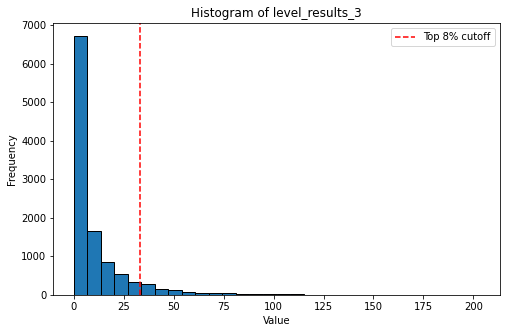

In [215]:
plt.figure(figsize=(8, 5))
plt.hist(level_results_3, bins=30, edgecolor='black')
cut_index = int(len(level_results_3) * 0.92)
threshold = np.partition(level_results_3, cut_index)[cut_index]
plt.axvline(threshold, color='red', linestyle='--', label='Top 8% cutoff')
plt.title("Histogram of level_results_3")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [160]:
estimate = 0
for i in range(p_sketch1.levels):
    level_results = query_subregion(p_sketch1, query_regions, level=i)
    print(f"Level {i}:")
    print(f"Count {len(level_results)}")
    print(f"Sum {level_results.sum()}")
    print(f"Avg {level_results.mean()}")
    # print(f"Approx {level_results.sum() - ((abs_error_eps / 10) *len(level_results))}")
    top_10_percent = int(len(level_results) * 0.08)
    highest_10_percent = np.sort(level_results)[-top_10_percent:]
    print(f"Approx {highest_10_percent.sum()}")
    estimate += highest_10_percent.sum()

print(f"\nTotal Estimate: {estimate}")


Level 0:
Count 1630
Sum 1056
Avg 0.6478527607361964
Approx 485
Level 1:
Count 5776
Sum 3388
Avg 0.5865650969529086
Approx 1490
Level 2:
Count 4154
Sum 7557
Avg 1.819210399614829
Approx 2660
Level 3:
Count 10972
Sum 113277
Avg 10.324188844331024
Approx 46598
Level 4:
Count 0
Sum 0.0
Avg nan
Approx 0.0

Total Estimate: 51233.0


/tmp/ipykernel_159890/2381918677.py:7: RuntimeWarning: Mean of empty slice.
  print(f"Avg {level_results.mean()}")


In [199]:
hash(query_regions[3][1])

903271411722680542

In [94]:
est, details = p_sketch2.query(queries["queries"][0], debug=True, detailed=True)

Categorical regions: 125
Indexed categorical regions: 125
Numerical regions: 1420
Indexed numerical regions: 967
Query regions: 120875
Level 0 queries: 18000
Level 1 queries: 58875
Level 2 queries: 19000
Level 3 queries: 25000


In [272]:
est, details = p_sketch1.query(queries["queries"][0], debug=True, detailed=True)

Categorical regions: 125
Indexed categorical regions: 125
Numerical regions: 1420
Indexed numerical regions: 948
Query regions: 22532
Level 0 queries: 1630
Level 1 queries: 5776
Level 2 queries: 4154
Level 3 queries: 10972


In [274]:
true_result = query_df(retail_df, queries["queries"][0])

In [276]:
np.abs(true_result - est) / len(retail_df)

np.float64(0.005912431792053648)